## Data Understanding

In this dataset, you are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be: 
- Activities
- Video clips
- Games
- Assessments. 

Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: 
- Bird Measurer
- Cart Balancer
- Cauldron Filler
- Chest Sorter 
- Mushroom Sorter.

The intent of the competition is to use the gameplay data to **forecast how many attempts a child will take to pass a given assessment** (an incorrect answer is counted as an attempt). Each application install is represented by an `installation_id`. This will typically correspond to one child, but you should expect noise from issues such as shared devices. 

In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. 
> **Note**: the training set contains many `installation_id`s which never took assessments, whereas every `installation_id` in the test set made an attempt on at least one assessment.

The outcomes in this competition are grouped into 4 groups (labeled `accuracy_group` in the data):

- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved

The file **train_labels.csv** has been provided to show how these groups would be computed on the assessments in the training set. 
> **Notes:** Assessment attempts are captured in `event_code` 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains `"correct":true`.

## Feature Understanding

- Each `installation_id` of a device has many `game_sessions`. 
- Each `game_session` has `event_id`, `game_time`, `title`, `type`, `world`. 
- Each `event_id` has its own `event_data` which includes `event_code` and `event_count`. `info` and `args`.
- A great analysis on features is conducted within [this work](https://www.kaggle.com/c/data-science-bowl-2019/discussion/119715).

In [1]:
import pandas as pd
import calendar
import json
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

%matplotlib inline

DATA_PATH = './data'

In [2]:
train = pd.read_csv(DATA_PATH + './train.csv')
specs = pd.read_csv(DATA_PATH + './specs.csv')
labels = pd.read_csv(DATA_PATH + './train_labels.csv')
test = pd.read_csv(DATA_PATH + './test.csv')

In [4]:
data = pd.merge(train, specs, on='event_id')

Eliminating `installation_id` that does not have any assessment attemps (neither `4110` nor `4100` with type `Assessment`).

There are instances with type `Game` and `event_code==4110` or `event_code==4100`.

In [5]:
keep_id = data[((data['event_code']==4110) | (data['event_code'] == 4100)) & 
               (data['type']=='Assessment')]['installation_id'].drop_duplicates()

In [9]:
print('Number of installation_id that we keep: ', len(keep_id))
print('Number of unique installation_id: ', train['installation_id'].nunique())

Number of installation_id that we keep:  3614
Number of unique installation_id:  17000


In [8]:
print('Number of unique installation_id in labels file: ',labels['installation_id'].nunique())

Number of unique installation_id in labels file:  3614


In [10]:
data = pd.merge(data, keep_id, on="installation_id", how="inner") # inner is the intersection of 2 dfs

## 1.1 Exploring the labels

In [11]:
labels.head()

game_session installation_id                         title  \
0  6bdf9623adc94d89        0006a69f  Mushroom Sorter (Assessment)   
1  77b8ee947eb84b4e        0006a69f    Bird Measurer (Assessment)   
2  901acc108f55a5a1        0006a69f  Mushroom Sorter (Assessment)   
3  9501794defd84e4d        0006a69f  Mushroom Sorter (Assessment)   
4  a9ef3ecb3d1acc6a        0006a69f    Bird Measurer (Assessment)   

   num_correct  num_incorrect  accuracy  accuracy_group  
0            1              0       1.0               3  
1            0             11       0.0               0  
2            1              0       1.0               3  
3            1              1       0.5               2  
4            1              0       1.0               3

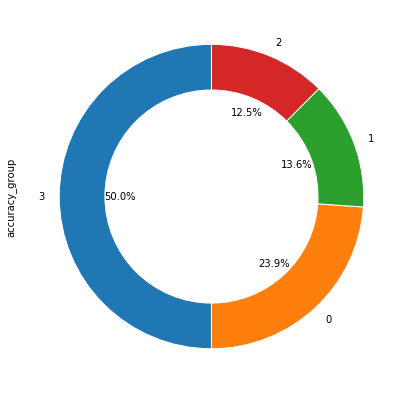

In [13]:
plt.figure(figsize=(7,7))
labels['accuracy_group'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                  startangle=90, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.show()

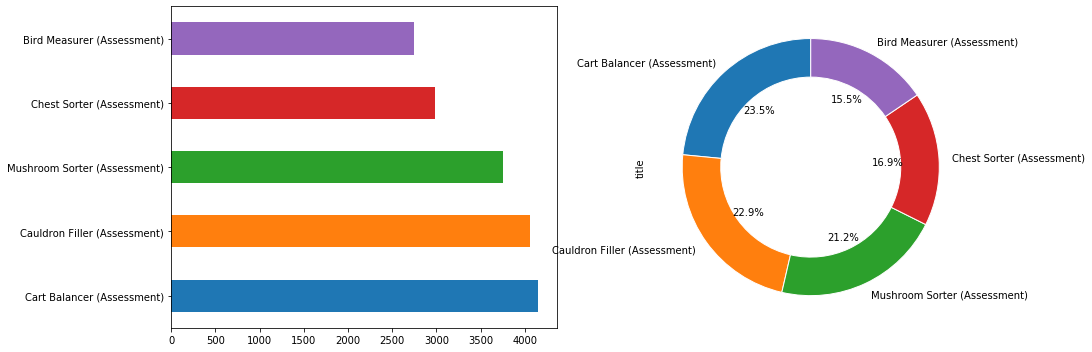

In [14]:
title_label = labels['title'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Get appropriate colors for different bars
bar_cmap = plt.get_cmap("tab10")
bar_colors = bar_cmap(np.arange(len(title_label)))

title_label.plot(kind='barh', ax=axes[0], color=bar_colors)
title_label.plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                  startangle=90, wedgeprops=dict(width=0.3, edgecolor='w'))

plt.tight_layout()
plt.show()

In [15]:
labels_ct = pd.crosstab(labels['title'], labels['accuracy_group'])
labels_ct

accuracy_group                   0    1    2     3
title                                             
Bird Measurer (Assessment)     886  778  389   693
Cart Balancer (Assessment)     576  353  470  2752
Cauldron Filler (Assessment)   421  459  630  2545
Chest Sorter (Assessment)     1752  466  256   507
Mushroom Sorter (Assessment)   594  355  460  2348


To customize `matplotlib` colormaps within the same hue value, checkout 
- [Matplotlib generic colormap from tab10](https://stackoverflow.com/questions/47222585/matplotlib-generic-colormap-from-tab10).
- [Matplotlib change colormap tab20 to have three colors](https://stackoverflow.com/questions/43938425/matplotlib-change-colormap-tab20-to-have-three-colors)

To utilize `sequential` colormap in matplotlib instead, refer this tutorial:
- [Nested Donut Plot using Sequential cmap](https://python-graph-gallery.com/163-donut-plot-with-subgroups/)

In [20]:
def generate_categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    '''
    Parameters:
        nc: The number of categories  
        nsc: The number of subcategories 
    Return:
        ListedColormap: A colormap with nc*nsc different colors, 
        where for each category there are nsc colors of same hue.
    '''
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

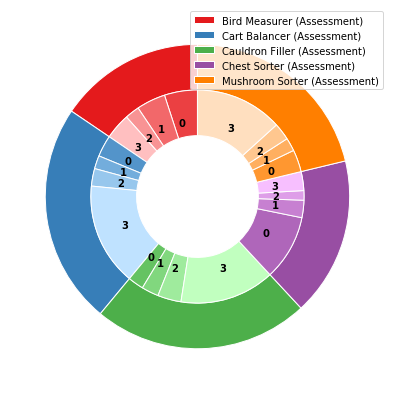

In [55]:
c1 = generate_categorical_cmap(5, 5, cmap="Set1")
fig, ax = plt.subplots(figsize=(7,7))

pie_cmap = plt.get_cmap(c1)
outer_colors = pie_cmap(np.arange(5)*5)
inner_colors = pie_cmap([1,2,3,4,
                         6,7,8,9,
                         11,12,13,14,
                         16,17,18,19,
                         21,22,23,24])

inner_names = list(np.sort(labels['accuracy_group'].unique()))*5

wedge_size = 0.3

outer_wedges, outer_texts = ax.pie(labels_ct.sum(axis=1), 
                                   radius=1, colors=outer_colors, startangle=90,
                                   wedgeprops=dict(width=wedge_size, edgecolor='w'))
ax.pie(labels_ct.values.flatten(), radius=1-wedge_size, colors=inner_colors, 
       startangle=90, labels=inner_names,
       wedgeprops=dict(width=wedge_size, edgecolor='w'), labeldistance=0.7,
       textprops=dict( weight='bold'))

ax.legend(outer_wedges, labels_ct.sum(axis=1).index)
plt.show()

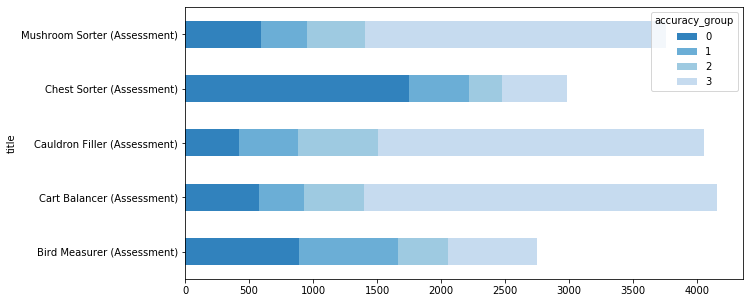

In [56]:
# Get appropriate colors for different bars
stacked_bar_cmap = plt.get_cmap("tab20c")
stacked_bar_colors = stacked_bar_cmap(np.arange(len(labels_ct.index)))

labels_ct.plot(kind='barh', stacked=True, figsize=(10,5), color=stacked_bar_colors)
plt.show()

In [57]:
norm_labels_ct = pd.crosstab(labels['title'], labels['accuracy_group'], normalize='index')
norm_labels_ct

accuracy_group                       0         1         2         3
title                                                               
Bird Measurer (Assessment)    0.322651  0.283321  0.141661  0.252367
Cart Balancer (Assessment)    0.138762  0.085040  0.113226  0.662973
Cauldron Filler (Assessment)  0.103822  0.113194  0.155364  0.627620
Chest Sorter (Assessment)     0.587722  0.156323  0.085877  0.170077
Mushroom Sorter (Assessment)  0.158105  0.094490  0.122438  0.624967

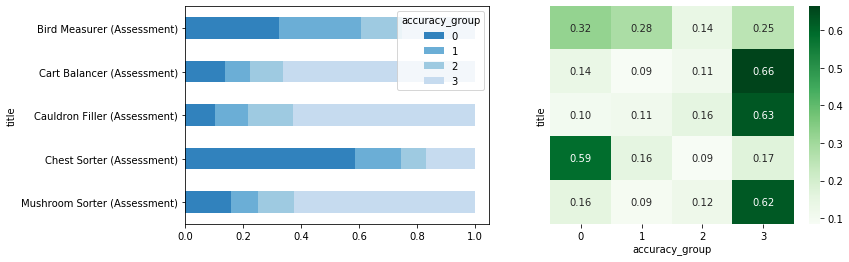

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

norm_labels_ct.plot(kind='barh', stacked='True', 
                    ax=axes[0], color=sns.color_palette("tab20c"))
sns.heatmap(norm_labels_ct, annot=True, fmt='.2f', 
            cmap='Greens', ax=axes[1], yticklabels=False)

# Invert the y_axis first subplot (barplot) 
# to be consistent with the heatmap y_axis
axes[0].invert_yaxis()
plt.show()

### Observations

- 50% the assessment was solved on the first attempt
- 12.5% the assessment was solved on the second attempt
- 13.6%: the assessment was solved after 3 or more attempts
- 23.9%: the assessment was never solved
---
- Number of assessments took are equally distributed.
---
- Cart Balancer, Mushroom Sorter and Cauldron Filler are easier assesments (As they have the higher # of solved on the first attemp)
- Chest Sorter is significantly hard as the number of never solved is much higher.

## 1.2 Exploring the Training Data

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 13 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
info               object
args               object
dtypes: int64(3), object(10)
memory usage: 826.1+ MB


### `worlds` 
- The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. 
- Possible values are: 
    - 'NONE' (at the app's start screen), 
    - TREETOPCITY' (Length/Height), 
    - 'MAGMAPEAK' (Capacity/Displacement), 
    - 'CRYSTALCAVES' (Weight).

### `types`
- Media type of the game or video. 
- Possible values are: 
    - 'Game', 'Assessment', 'Activity', 'Clip'.

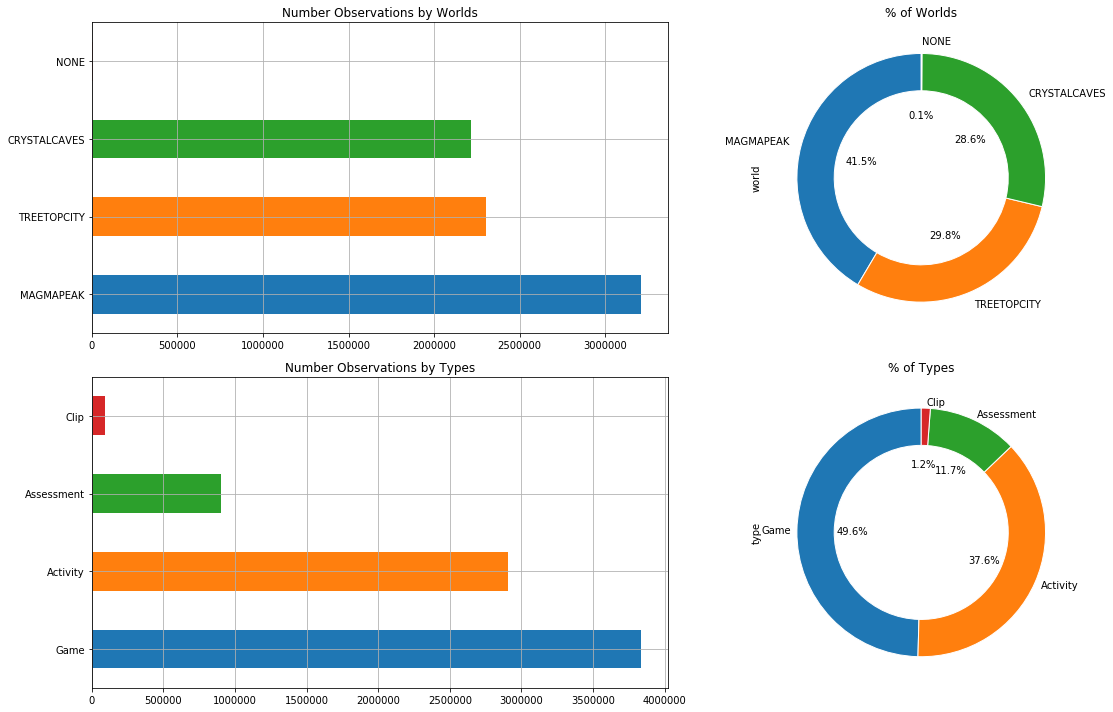

In [60]:
world_counts = data['world'].value_counts()
type_counts = data['type'].value_counts()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17,10))

# Get appropriate colors for different bars
bar_cmap = plt.get_cmap("tab10")
bar_colors = bar_cmap(np.arange(len(world_counts)))

world_counts.plot(kind='barh', ax=axes[0,0], color=bar_colors)
world_counts.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', pctdistance=0.5,
                  startangle=90, wedgeprops=dict(width=0.3, edgecolor='w'))

type_counts.plot(kind='barh', ax=axes[1,0], color=bar_colors)
type_counts.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', pctdistance=0.55, labeldistance=1.05,
                  startangle=90, wedgeprops=dict(width=0.3, edgecolor='w'))

axes[0,0].set_title('Number Observations by Worlds')
axes[0,1].set_title('% of Worlds')
axes[1,0].set_title('Number Observations by Types')
axes[1,1].set_title('% of Types')

axes[0,0].grid()
axes[1,0].grid()

plt.tight_layout()
plt.show()

### `title ` 

- Title of the game or video.

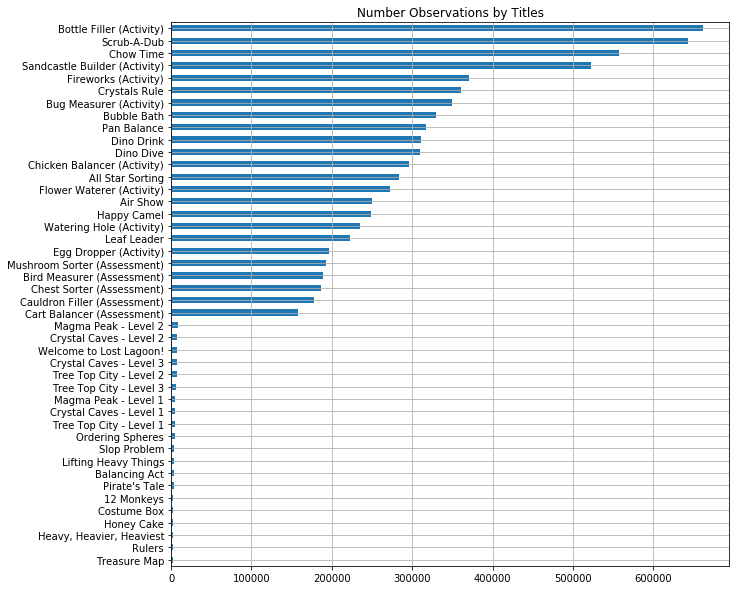

In [61]:
title_counts = data.title.value_counts().sort_values(ascending=True)
title_counts.plot(kind='barh', figsize=(10,10))

plt.title("Number Observations by Titles")
plt.grid()
plt.show()

In [62]:
data['game_time'].value_counts()

0         191897
391          766
388          762
395          750
390          712
           ...  
379231         1
293225         1
280943         1
267125         1
265123         1
Name: game_time, Length: 673592, dtype: int64

In [63]:
data['game_time'].apply(np.log1p).value_counts()

0.000000     191897
5.971262        766
5.963579        762
5.981414        750
5.968708        712
              ...  
12.783677         1
16.196532         1
12.931786         1
13.324577         1
14.076018         1
Name: game_time, Length: 673592, dtype: int64

### `game_time` 
- Time in milliseconds since the start of the game session.
- Extracted from `event_data`

Take a log transformation to see more easily the distribution. 

The log1p transform shows a somewhat normal distribution with a peak at zero.

In [64]:
data['game_time_log'] = data['game_time'].apply(np.log1p)

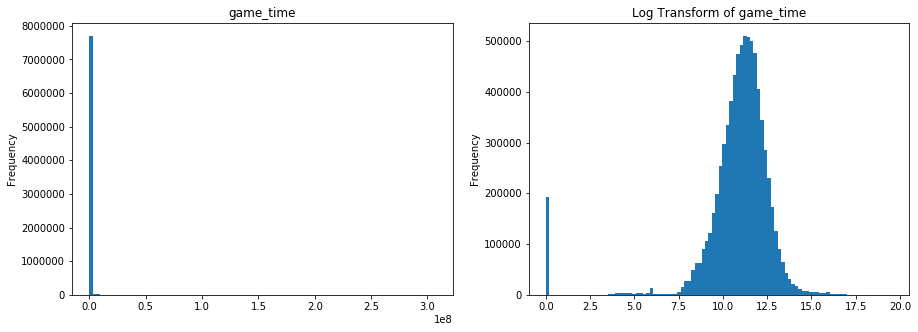

In [65]:
plt.subplot(1, 2, 1)
data['game_time'].plot(kind='hist',
                      figsize=(15, 5),
                      bins=100,
                      title='game_time')
plt.subplot(1, 2, 2)
data['game_time_log'].plot(kind='hist',
                          figsize=(15, 5),
                          bins=100,
                          title='Log Transform of game_time')
plt.show()

### `game_time` vs `type` and `world`

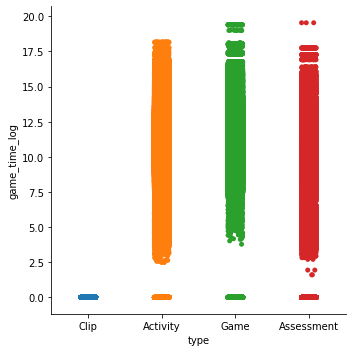

In [66]:
sns.catplot(x='type', y='game_time_log', data = data)

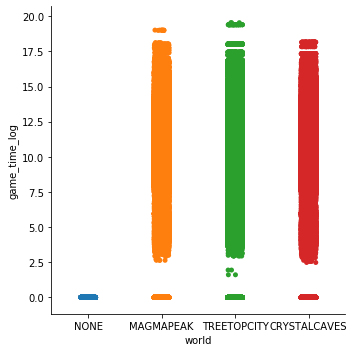

In [67]:
sns.catplot(x='world', y='game_time_log', data = data)
plt.show()

### `timestamp` 
- Client-generated datetime

In [68]:
def get_time(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    return df
    
data = get_time(data)

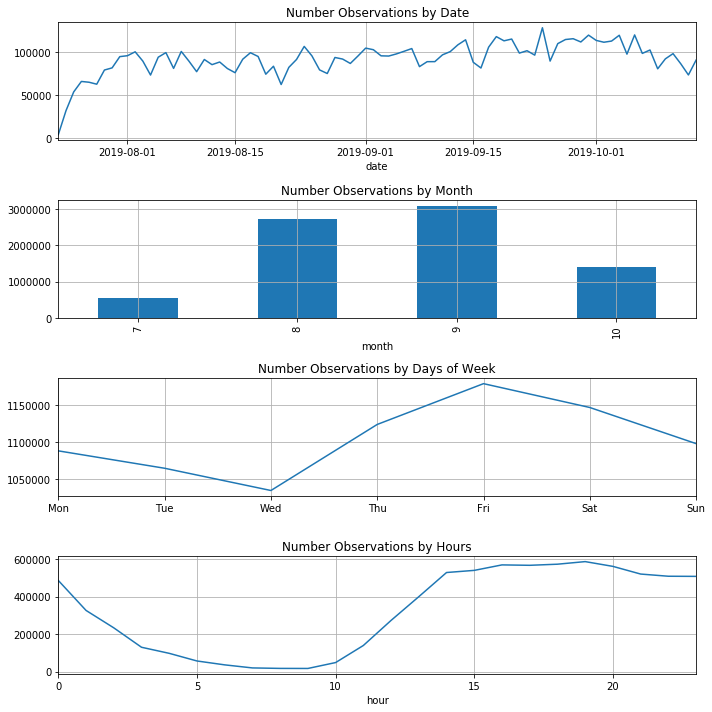

In [69]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,10))

date_counts = data.groupby('date')['date'].count()
month_counts = data.groupby('month')['month'].count()
dow_counts = data.groupby('dayofweek')['dayofweek'].count()
dow_counts.index = list(calendar.day_abbr)
hour_counts = data.groupby('hour')['hour'].count()

date_counts.plot(ax=axes[0])
month_counts.plot(kind='bar', ax=axes[1])
dow_counts.plot(ax=axes[2])
hour_counts.plot(ax=axes[3])


axes[0].set_title('Number Observations by Date')
axes[1].set_title('Number Observations by Month')
axes[2].set_title('Number Observations by Days of Week')
axes[3].set_title('Number Observations by Hours')

for ax in axes:
    ax.grid()
    
plt.tight_layout()
plt.show()

## References

- https://www.kaggle.com/erikbruin/data-science-bowl-2019-eda-and-baseline
- https://www.kaggle.com/robikscube/2019-data-science-bowl-an-introduction

A more into detailed EDA is:
- https://www.kaggle.com/subbuvolvosekar/eda-visualization-story-dsb-2019